In [1]:
import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils
plt.rcParams['figure.figsize'] = (13, 5)

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from collections import Counter
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [2]:
features = utils.load('data/fma_metadata/DBMERGEfeatures.csv')

features.shape

(25000, 520)

In [3]:
features.head()

feature    metadata           chroma_cens                                \
statistics      set     track    kurtosis                                 
number       subset genre_top          01        02        03        04   
track_id                                                                  
2             small   Hip-Hop    7.180653  5.230309  0.249321  1.347620   
3            medium   Hip-Hop    1.888963  0.760539  0.345297  2.295201   
5             small   Hip-Hop    0.527563 -0.077654 -0.279610  0.685883   
10            small       Pop    3.702245 -0.291193  2.196742 -0.234449   
134          medium   Hip-Hop    0.918445  0.674147  0.577818  1.281117   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            05        06        07        08  ...        04        05   
track_id                                            ...                       
2           1.482478  0.531371  1.481593  2.691455  ...  0.054125  0.012226   
3           1.654031  0.067592  1.366848  1.054094  ...  0.063831  0.014212   
5           1.937570  0.880839 -0.923192 -0.927232  ...  0.040730  0.012691   
10          1.367364  0.998411  1.770694  1.604566  ...  0.074358  0.017952   
134         0.933746  0.078177  1.199204 -0.175223  ...  0.058766  0.016322   

feature                     zcr                                               \
statistics             kurtosis       max      mean    median  min      skew   
number            06         01        01        01        01   01        01   
track_id                                                                       
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.0  2.089872   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.0  1.716724   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.0  2.193303   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.0  3.542325   
134         0.015819   4.731087  0.419434  0.064370  0.050781  0.0  1.806106   

feature               
statistics       std  
number            01  
track_id              
2           0.061448  
3           0.069330  
5           0.044861  
10          0.040800  
134         0.054623  

[5 rows x 520 columns]

In [4]:
features.loc[2,:]

feature      statistics  number   
metadata     set         subset           small
             track       genre_top      Hip-Hop
chroma_cens  kurtosis    01             7.18065
                         02             5.23031
                         03            0.249321
                                        ...    
zcr          mean        01           0.0856294
             median      01           0.0712891
             min         01                   0
             skew        01             2.08987
             std         01           0.0614481
Name: 2, Length: 520, dtype: object

In [5]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 2 to 155314
Columns: 520 entries, ('metadata', 'set', 'subset') to ('zcr', 'std', '01')
dtypes: float64(518), object(2)
memory usage: 100.0+ MB


In [6]:
features['metadata','track','genre_top'].value_counts()

Rock                   7103
Electronic             6314
Experimental           2251
Hip-Hop                2201
Folk                   1519
Instrumental           1350
Pop                    1186
International          1018
Classical               619
Old-Time / Historic     510
Jazz                    384
Country                 178
Soul-RnB                154
Spoken                  118
Blues                    74
Easy Listening           21
Name: (metadata, track, genre_top), dtype: int64

In [7]:
##features=features.loc[(features[('metadata','track','genre_top')] == 'Easy Listening') | (features[('metadata','track','genre_top')] == 'Blues') |(features[('metadata','set','subset')] == 'small')]

In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 2 to 155314
Columns: 520 entries, ('metadata', 'set', 'subset') to ('zcr', 'std', '01')
dtypes: float64(518), object(2)
memory usage: 100.0+ MB


In [9]:
features['metadata','track','genre_top'].value_counts()

Rock                   7103
Electronic             6314
Experimental           2251
Hip-Hop                2201
Folk                   1519
Instrumental           1350
Pop                    1186
International          1018
Classical               619
Old-Time / Historic     510
Jazz                    384
Country                 178
Soul-RnB                154
Spoken                  118
Blues                    74
Easy Listening           21
Name: (metadata, track, genre_top), dtype: int64

In [10]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 2 to 155314
Columns: 520 entries, ('metadata', 'set', 'subset') to ('zcr', 'std', '01')
dtypes: float64(518), object(2)
memory usage: 100.0+ MB


## SELEZIONE ATTRIBUTI, PRIMA CON CORRELAZIONE POI CON UNIVARIATE FEATURES SELECTION. TRASFORMO ANCHE IL LABEL IN NUMERICO

In [11]:
# Create correlation matrix
corr_matrix = features.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.50
to_drop = [column for column in upper.columns if any(upper[column] > 0.60)]

# Drop features 
features.drop(to_drop, axis=1, inplace=True)

In [12]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 2 to 155314
Columns: 193 entries, ('metadata', 'set', 'subset') to ('zcr', 'kurtosis', '01')
dtypes: float64(191), object(2)
memory usage: 37.6+ MB


In [13]:

# creating instance of labelencoder
le = LabelEncoder()
features[('metadata','track','genre_top_Cat')] = le.fit_transform(features[('metadata','track','genre_top')])



In [14]:
features.head()

feature    metadata           chroma_cens                                \
statistics      set     track    kurtosis                                 
number       subset genre_top          01        02        03        04   
track_id                                                                  
2             small   Hip-Hop    7.180653  5.230309  0.249321  1.347620   
3            medium   Hip-Hop    1.888963  0.760539  0.345297  2.295201   
5             small   Hip-Hop    0.527563 -0.077654 -0.279610  0.685883   
10            small       Pop    3.702245 -0.291193  2.196742 -0.234449   
134          medium   Hip-Hop    0.918445  0.674147  0.577818  1.281117   

feature                                             ...   tonnetz            \
statistics                                          ...       min      skew   
number            05        06        07        08  ...        06        01   
track_id                                            ...                       
2           1.482478  0.531371  1.481593  2.691455  ... -0.089286  0.752462   
3           1.654031  0.067592  1.366848  1.054094  ... -0.055667  0.265541   
5           1.937570  0.880839 -0.923192 -0.927232  ... -0.146136  1.212025   
10          1.367364  0.998411  1.770694  1.604566  ... -0.029836 -0.135219   
134         0.933746  0.078177  1.199204 -0.175223  ... -0.053569  0.927807   

feature                                                                 \
statistics                                                         std   
number            02        03        04        05        06        01   
track_id                                                                 
2           0.262607  0.200944  0.593595 -0.177665 -1.424201  0.019809   
3          -0.131471  0.171930 -0.990710  0.574556  0.556494  0.026316   
5           0.218381 -0.419971 -0.014541 -0.199314 -0.925733  0.025550   
10         -0.275780  0.015767 -1.094873  1.164041  0.246746  0.021413   
134        -0.947771  0.143864 -0.529867  0.162188  0.063846  0.024258   

feature           zcr      metadata  
statistics   kurtosis         track  
number             01 genre_top_Cat  
track_id                             
2            5.758890             7  
3            2.824694             7  
5            6.808415             7  
10          21.434212            12  
134          4.731087             7  

[5 rows x 194 columns]

In [15]:
features['metadata','track'].drop_duplicates()

C:\Users\Federico\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


number,genre_top,genre_top_Cat
track_id,,
2,Hip-Hop,7
10,Pop,12
136,Rock,13
139,Folk,6
148,Experimental,5
237,Jazz,10
397,Electronic,4
666,International,9
734,Soul-RnB,14


In [16]:

attributes = [col for col in features.columns if (col != ('metadata','track','genre_top') and 
                                                  col != ('metadata','set','subset')  and
                                                 col != ('metadata','track','genre_top_Cat'))] 

X = features[attributes].values
y = features[('metadata','track','genre_top_Cat')]

In [17]:
sel=SelectKBest(k=20)
X_sel=sel.fit_transform(X,y)
df=features.drop([('metadata', 'track','genre_top'),('metadata','set','subset'),('metadata','track','genre_top_Cat')], axis = 1)

feat_importance=dict(zip(df.columns,sel.scores_))
feat_importance

{('chroma_cens', 'kurtosis', '01'): 20.46156353355033,
 ('chroma_cens', 'kurtosis', '02'): 29.24141641071257,
 ('chroma_cens', 'kurtosis', '03'): 3.8934992860852793,
 ('chroma_cens', 'kurtosis', '04'): 11.560085613808157,
 ('chroma_cens', 'kurtosis', '05'): 16.728558988292857,
 ('chroma_cens', 'kurtosis', '06'): 13.98007179936684,
 ('chroma_cens', 'kurtosis', '07'): 27.069128606776776,
 ('chroma_cens', 'kurtosis', '08'): 18.294263051124336,
 ('chroma_cens', 'kurtosis', '09'): 26.265720649330657,
 ('chroma_cens', 'kurtosis', '10'): 21.40698860449529,
 ('chroma_cens', 'kurtosis', '11'): 7.846625754412351,
 ('chroma_cens', 'kurtosis', '12'): 16.808930660331495,
 ('chroma_cens', 'max', '01'): 63.69861370867771,
 ('chroma_cens', 'max', '02'): 62.49783047622246,
 ('chroma_cens', 'max', '03'): 71.55308698270295,
 ('chroma_cens', 'max', '04'): 51.4299495851714,
 ('chroma_cens', 'max', '05'): 67.21929467867332,
 ('chroma_cens', 'max', '06'): 52.64116720604791,
 ('chroma_cens', 'max', '07'): 62.

In [18]:
dict(sorted(feat_importance.items(), key=lambda item: item[1]))

{('chroma_cqt', 'max', '02'): 0.6108523985346628,
 ('chroma_cqt', 'max', '01'): 1.337155111723517,
 ('chroma_stft', 'max', '05'): 1.8148728469650715,
 ('chroma_stft', 'max', '12'): 2.5425134916903653,
 ('chroma_stft', 'max', '02'): 2.730473851722338,
 ('chroma_cqt', 'kurtosis', '03'): 2.7946232395488693,
 ('rmse', 'min', '01'): 2.8119293584640026,
 ('tonnetz', 'skew', '04'): 2.919914312750558,
 ('chroma_cqt', 'max', '10'): 3.041321394563569,
 ('tonnetz', 'skew', '05'): 3.07118379388982,
 ('chroma_stft', 'max', '11'): 3.428095991841382,
 ('tonnetz', 'skew', '03'): 3.4600647584137847,
 ('chroma_cqt', 'max', '05'): 3.4630112891358213,
 ('chroma_cens', 'kurtosis', '03'): 3.8934992860852793,
 ('chroma_cqt', 'max', '09'): 5.165945620577623,
 ('chroma_stft', 'max', '01'): 5.580785846814379,
 ('chroma_stft', 'max', '06'): 5.812810506095075,
 ('tonnetz', 'mean', '03'): 5.826733199159965,
 ('chroma_stft', 'kurtosis', '01'): 6.244777946516988,
 ('chroma_cqt', 'max', '12'): 6.312400922298908,
 ('t

In [19]:
a1_sorted_keys = sorted(feat_importance, key=feat_importance.get, reverse=True)
a1_sorted_keys
for r in a1_sorted_keys:
    print(r, feat_importance[r])

('mfcc', 'max', '04') 858.7115328485476
('mfcc', 'max', '01') 768.1876850328107
('mfcc', 'max', '03') 416.7931043863304
('mfcc', 'max', '07') 384.3081626020349
('spectral_bandwidth', 'kurtosis', '01') 357.20514552817275
('mfcc', 'mean', '02') 340.05550305373316
('chroma_stft', 'mean', '01') 290.3805206642753
('mfcc', 'std', '04') 281.83990740342466
('mfcc', 'std', '02') 280.3960742957319
('spectral_contrast', 'max', '04') 267.937144552194
('mfcc', 'min', '04') 265.648429894638
('mfcc', 'std', '01') 258.5105522377112
('mfcc', 'skew', '04') 247.34800125416925
('mfcc', 'min', '05') 247.15955683445276
('spectral_contrast', 'max', '03') 240.36888675470092
('mfcc', 'min', '02') 234.07229596094027
('mfcc', 'max', '11') 221.97834966485107
('tonnetz', 'std', '01') 218.3906700859561
('spectral_contrast', 'min', '02') 216.42335587533216
('mfcc', 'min', '11') 208.4283609975846
('mfcc', 'min', '10') 190.96674790804636
('spectral_contrast', 'max', '02') 190.80998519150293
('mfcc', 'mean', '11') 190.

In [20]:
df_ridotto=df[df.columns[sel.get_support()]]
df_ridotto

feature    chroma_stft       mfcc                                    \
statistics        mean        max                                     
number              01         01         03          04         07   
track_id                                                              
2             0.696063  28.657707  52.424423  103.289833  37.843021   
3             0.449602  29.380682  76.742714  137.245010  55.662521   
5             0.481160 -40.500740  50.373932  112.312531  29.266182   
10            0.388109  20.196968  60.412815   78.466721  21.597277   
134           0.438062 -41.723225  58.687328  125.922821  37.450359   
...                ...        ...        ...         ...        ...   
155297        0.408626   3.826046  94.208336   48.085751  26.723190   
155298        0.439034 -72.790154  81.013275  124.569000  29.571426   
155306        0.369401  -7.814734  88.024063  116.180260  29.388819   
155307        0.357939 -13.889938  62.219879   93.028778  41.311356   
155314        0.551894 -15.305521  32.737503   95.054657  25.620636   

feature                                                                \
statistics                   mean           min                         
number             11          02            02         04         05   
track_id                                                                
2           27.737400  116.696678 -1.421085e-14 -51.569004 -97.879890   
3           26.740063  120.158501 -1.851665e+01 -12.548506 -87.048355   
5           27.197964  132.215073 -6.228398e+01 -24.319845 -74.060310   
10          24.780317  157.040085  5.151435e-14 -50.578659 -45.113949   
134         36.486378  125.521309 -9.427860e-01 -90.334747 -67.671829   
...               ...         ...           ...        ...        ...   
155297      19.866936  163.954620 -1.776357e-14 -29.221125 -28.104187   
155298      38.472843  160.770218 -7.993606e-14  -7.314378 -69.236115   
155306      47.185654  177.614151  5.329071e-15 -49.451691 -70.841232   
155307      33.690544  124.228142 -5.892177e+00 -50.547176 -99.119080   
155314      34.402496  166.692734 -2.464827e-01 -55.172737 -55.477066   

feature                                                            \
statistics                 skew         std                         
number             11        04          01         02         04   
track_id                                                            
2          -49.195107  0.043292   97.809044  38.569584  20.767921   
3          -46.103527 -0.026875  111.686371  41.191982  22.025253   
5          -46.700871 -0.108640   95.049904  39.367599  24.319347   
10         -33.503983 -0.561734  102.743553  44.409843  14.013119   
134        -46.685959 -0.479446  102.779747  47.266518  36.841534   
...               ...       ...         ...        ...        ...   
155297     -19.892073  0.369148   91.869461  30.287067  12.060067   
155298     -33.599331  0.602545   94.696381  39.359367  18.604885   
155306     -25.193905  0.172813  109.087028  40.537926  28.671246   
155307     -31.271780 -0.412079   80.234474  35.382370  22.123117   
155314     -41.693249 -1.755459   64.040298  26.786989  22.369673   

feature    spectral_bandwidth spectral_contrast                        tonnetz  
statistics           kurtosis               max                  min       std  
number                     01                03         04        02        01  
track_id                                                                        
2                    3.874384         39.333603  31.513493  2.296826  0.019809  
3                    2.383340         42.141411  31.473713  0.652681  0.026316  
5                    0.895442         39.017235  33.707951  2.314010  0.025550  
10                   0.437628         45.410881  28.711344  4.415900  0.021413  
134                  0.372903         41.526760  32.224319  1.270560  0.024258  
...                       ...               ...        ...       ...     

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 20 Text major ticklabel objects>)

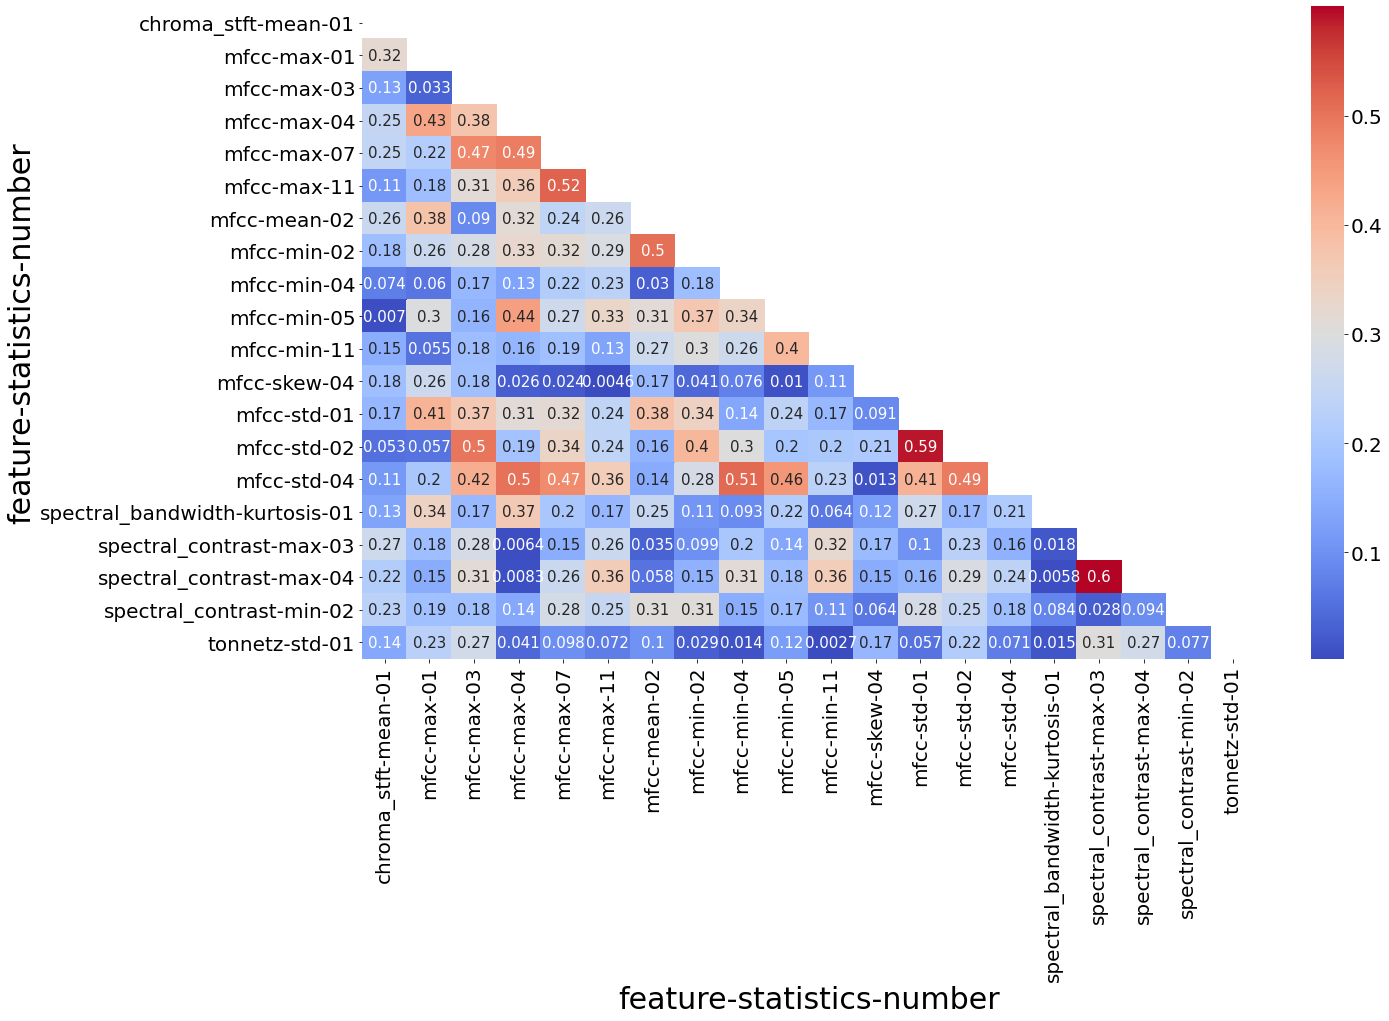

In [31]:
SMALL_SIZE = 30
MEDIUM_SIZE = 40
BIGGER_SIZE = 40

plt.rc('font', size=15) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=20) # fontsize of the tick labels
plt.rc('ytick', labelsize=20) # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title
plt.figure(figsize=(20, 12))
corr=df_ridotto.corr()
mask=np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr.abs(),annot=True,cmap="coolwarm",mask=mask);
plt.xticks(rotation=90)

In [22]:
df_analisi=df_ridotto.copy()
df_analisi[('metadata','set','subset')]=features[[('metadata','set','subset')]].copy() 

In [22]:
df_analisi[('metadata','track','genre_top')]=features[('metadata','track','genre_top')].copy() 

In [23]:
df_analisi[('metadata','track','genre_top_Cat')]=y

In [24]:
df_analisi.head()

feature    chroma_stft       mfcc                                    \
statistics        mean        max                                     
number              01         01         03          04         07   
track_id                                                              
2             0.696063  28.657707  52.424423  103.289833  37.843021   
3             0.449602  29.380682  76.742714  137.245010  55.662521   
5             0.481160 -40.500740  50.373932  112.312531  29.266182   
10            0.388109  20.196968  60.412815   78.466721  21.597277   
134           0.438062 -41.723225  58.687328  125.922821  37.450359   

feature                                                                ...  \
statistics                   mean           min                        ...   
number             11          02            02         04         05  ...   
track_id                                                               ...   
2           27.737400  116.696678 -1.421085e-14 -51.569004 -97.879890  ...   
3           26.740063  120.158501 -1.851665e+01 -12.548506 -87.048355  ...   
5           27.197964  132.215073 -6.228398e+01 -24.319845 -74.060310  ...   
10          24.780317  157.040085  5.151435e-14 -50.578659 -45.113949  ...   
134         36.486378  125.521309 -9.427860e-01 -90.334747 -67.671829  ...   

feature                          spectral_bandwidth spectral_contrast  \
statistics        std                      kurtosis               max   
number             02         04                 01                03   
track_id                                                                
2           38.569584  20.767921           3.874384         39.333603   
3           41.191982  22.025253           2.383340         42.141411   
5           39.367599  24.319347           0.895442         39.017235   
10          44.409843  14.013119           0.437628         45.410881   
134         47.266518  36.841534           0.372903         41.526760   

feature                           tonnetz metadata                          
statistics                  min       std      set     track                
number             04        02        01   subset genre_top genre_top_Cat  
track_id                                                                    
2           31.513493  2.296826  0.019809    small   Hip-Hop             7  
3           31.473713  0.652681  0.026316   medium   Hip-Hop             7  
5           33.707951  2.314010  0.025550    small   Hip-Hop             7  
10          28.711344  4.415900  0.021413    small       Pop            12  
134         32.224319  1.270560  0.024258   medium   Hip-Hop             7  

[5 rows x 23 columns]

In [25]:
df_analisi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 2 to 155314
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   (chroma_stft, mean, 01)             25000 non-null  float64
 1   (mfcc, max, 01)                     25000 non-null  float64
 2   (mfcc, max, 03)                     25000 non-null  float64
 3   (mfcc, max, 04)                     25000 non-null  float64
 4   (mfcc, max, 07)                     25000 non-null  float64
 5   (mfcc, max, 11)                     25000 non-null  float64
 6   (mfcc, mean, 02)                    25000 non-null  float64
 7   (mfcc, min, 02)                     25000 non-null  float64
 8   (mfcc, min, 04)                     25000 non-null  float64
 9   (mfcc, min, 05)                     25000 non-null  float64
 10  (mfcc, min, 11)                     25000 non-null  float64
 11  (mfcc, skew, 04)                    2500

In [26]:
df_analisi.to_csv('data/fma_metadata/df_analisi.csv', index = True)


In [27]:
df_ridotto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 2 to 155314
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   (chroma_stft, mean, 01)             25000 non-null  float64
 1   (mfcc, max, 01)                     25000 non-null  float64
 2   (mfcc, max, 03)                     25000 non-null  float64
 3   (mfcc, max, 04)                     25000 non-null  float64
 4   (mfcc, max, 07)                     25000 non-null  float64
 5   (mfcc, max, 11)                     25000 non-null  float64
 6   (mfcc, mean, 02)                    25000 non-null  float64
 7   (mfcc, min, 02)                     25000 non-null  float64
 8   (mfcc, min, 04)                     25000 non-null  float64
 9   (mfcc, min, 05)                     25000 non-null  float64
 10  (mfcc, min, 11)                     25000 non-null  float64
 11  (mfcc, skew, 04)                    2500

In [28]:

attributes = [col for col in df_ridotto.columns] 

X = df_ridotto[attributes].values
y = features[('metadata','track','genre_top_Cat')]

## DECISION TREE

In [1]:
X_train, X_test, y_train, y_test = train_test_split(df_ridotto, y, test_size=0.3, random_state=1, stratify=y)


NameError: name 'train_test_split' is not defined

In [37]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [1]:
param_grid = {'criterion': ['gini', 'entropy'],
              'min_samples_split' : range(10,70,10),
              'min_samples_leaf' : range(10,70,10),
              'max_depth': range(5, 20, 3)}


clf1 = RandomizedSearchCV(DecisionTreeClassifier(), 
                         param_grid, cv=StratifiedKFold(5), scoring='balanced_accuracy')

clf1 = clf1.fit(X_train, y_train)
report(clf1.cv_results_, n_top=5)


NameError: name 'RandomizedSearchCV' is not defined

In [30]:
#clf1 = DecisionTreeClassifier()
#clf1 = clf1.fit(X_train, y_train)
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=11, min_samples_split=90, min_samples_leaf=40)
clf1 = clf1.fit(X_train, y_train)


In [31]:
clf1.get_depth()

11

In [32]:
clf1.get_n_leaves()

291

In [33]:
clf1.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 11,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 40,
 'min_samples_split': 90,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [34]:
for col, imp in zip(attributes, clf1.feature_importances_):
    print(col, imp)
    

('chroma_stft', 'mean', '01') 0.03792828037428982
('mfcc', 'max', '01') 0.18887896602664608
('mfcc', 'max', '03') 0.06944477410569427
('mfcc', 'max', '04') 0.1256374355294027
('mfcc', 'max', '07') 0.02437494781453628
('mfcc', 'max', '11') 0.00774726171007775
('mfcc', 'mean', '02') 0.11202355117269736
('mfcc', 'min', '02') 0.007338325696360785
('mfcc', 'min', '04') 0.013505434229421905
('mfcc', 'min', '05') 0.02078086070534
('mfcc', 'min', '11') 0.030594689895012527
('mfcc', 'skew', '04') 0.020638214106053526
('mfcc', 'std', '01') 0.019048081071402923
('mfcc', 'std', '02') 0.02685758802387057
('mfcc', 'std', '04') 0.09333480485122837
('spectral_bandwidth', 'kurtosis', '01') 0.0159994818800178
('spectral_contrast', 'max', '03') 0.028722505858578967
('spectral_contrast', 'max', '04') 0.06372267615344859
('spectral_contrast', 'min', '02') 0.04084065408289948
('tonnetz', 'std', '01') 0.05258146671302038


In [35]:
y_pred_tr = clf1.predict(X_train)
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print('Val Recall %s' % recall_score(y_train, y_pred_tr,average=None))
print('Val Precision %s' % precision_score(y_train, y_pred_tr,average=None))

print(classification_report(y_train, y_pred_tr))

confusion_matrix(y_train, y_pred_tr)


Train Accuracy 0.5333142857142857
Train F1-score [0.         0.54503991 0.         0.         0.61578164 0.23032787
 0.40513834 0.4488189  0.36332767 0.25863596 0.         0.84856397
 0.03824522 0.66759099 0.         0.19847328]
Val Recall [0.         0.55196305 0.         0.         0.70180995 0.17829949
 0.38570085 0.40687865 0.33968254 0.20476858 0.         0.91036415
 0.02048193 0.77473854 0.         0.15853659]
Val Precision [0.         0.53828829 0.         0.         0.54854111 0.32523148
 0.42663892 0.50039904 0.39051095 0.35096154 0.         0.79462103
 0.28813559 0.5864799  0.         0.26530612]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.54      0.55      0.55       433
           2       0.00      0.00      0.00       124
           3       0.00      0.00      0.00        15
           4       0.55      0.70      0.62      4420
           5       0.33      0.18      0.23      1576
       

C:\Users\Federico\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Federico\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[   0,    3,    0,    0,   11,    4,    6,    4,    1,    1,    0,
           0,    0,   21,    0,    1],
       [   0,  239,    0,    0,   27,   26,   14,    0,   97,   11,    0,
           3,    0,   15,    0,    1],
       [   0,    0,    0,    0,   11,    2,   20,    9,    1,    6,    0,
           0,    0,   74,    0,    1],
       [   0,    0,    0,    0,    2,    3,    1,    0,    3,    0,    0,
           0,    0,    6,    0,    0],
       [   0,   41,    0,    0, 3102,  141,   66,  262,  104,   39,    0,
           9,   11,  645,    0,    0],
       [   0,   38,    0,    0,  492,  281,   79,   52,  111,   31,    0,
          32,    5,  451,    0,    4],
       [   0,   21,    0,    0,  121,   48,  410,   22,   38,   57,    0,
           6,    3,  337,    0,    0],
       [   0,    0,    0,    0,  548,   21,   26,  627,    3,    8,    0,
           0,    6,  296,    0,    6],
       [   0,   56,    0,    0,  214,   89,   31,    5,  321,   18,    0,
          13,    2,  1

In [60]:
y_pred = clf1.predict(X_test)

print('Val Accuracy %0.4f' % accuracy_score(y_test, y_pred))


print('Train F1-score %s' % f1_score(y_test, y_pred, average='micro'))
print('Val Recall %s' % recall_score(y_test, y_pred,average='micro'))
print('Val Precision %s' % precision_score(y_test, y_pred,average='micro'))

print(classification_report(y_test, y_pred))

confusion_matrix(y_test, y_pred)

Val Accuracy 0.4825
Train F1-score 0.4825333333333333
Val Recall 0.4825333333333333
Val Precision 0.4825333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.43      0.47      0.45       186
           2       0.00      0.00      0.00        54
           3       0.00      0.00      0.00         6
           4       0.51      0.64      0.57      1894
           5       0.25      0.12      0.17       675
           6       0.37      0.33      0.35       456
           7       0.44      0.35      0.39       660
           8       0.29      0.26      0.28       405
           9       0.21      0.12      0.15       305
          10       0.00      0.00      0.00       115
          11       0.72      0.90      0.80       153
          12       0.11      0.01      0.01       356
          13       0.55      0.73      0.63      2131
          14       0.00      0.00      0.00        46
          15      

C:\Users\Federico\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[   0,    1,    0,    0,    3,    3,    2,    0,    0,    3,    0,
           0,    0,   10,    0,    0],
       [   0,   87,    0,    0,   11,   17,    7,    0,   49,    5,    0,
           1,    0,    9,    0,    0],
       [   0,    0,    0,    0,    9,    0,    6,    1,    2,    2,    0,
           0,    0,   34,    0,    0],
       [   0,    0,    0,    0,    3,    1,    0,    1,    0,    0,    0,
           0,    0,    1,    0,    0],
       [   0,   26,    0,    0, 1213,   75,   39,  122,   60,   17,    0,
           7,    2,  332,    0,    1],
       [   0,   24,    0,    0,  200,   84,   32,   15,   65,   18,    0,
          23,    2,  205,    0,    7],
       [   0,   11,    0,    0,   44,   13,  150,   14,   19,   29,    0,
           2,    2,  172,    0,    0],
       [   0,    0,    0,    0,  254,   10,   12,  231,    4,    5,    0,
           0,    3,  139,    0,    2],
       [   0,   27,    0,    0,   99,   41,   24,    1,  107,    7,    0,
           6,    0,   

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 1.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[   0    1    0    0    3    3    2    0    0    3    0    0    0   10
     0    0]
 [   0   87    0    0   11   17    7    0   49    5    0    1    0    9
     0    0]
 [   0    0    0    0    9    0    6    1    2    2    0    0    0   34
     0    0]
 [   0    0    0    0    3    1    0    1    0    0    0    0    0    1
     0    0]
 [   0   26    0    0 1213   75   39  122   60   17    0    7    2  332
     0    1]
 [   0   24    0    0  200   84   32   15   65   18    0   23    2  205
     0    7]
 [   0   11    0    0   44   13  150   14   19   29    0    2    2  172
     0    0]
 [   0    0    0    0  254   10   12  231    4    5    0    0    3  139
     0    2]
 [   0   27    0    0   99   41   24    1  107    7    0    6    0   90
     0    3]
 [   0    7    0    0   91   18   26   30    3   36    0    1    0   90
     0    3]
 [   0    9    0    0   33    6    5    2   18    6    0    0    1   35
     0    0]
 [   0    0    0    0    

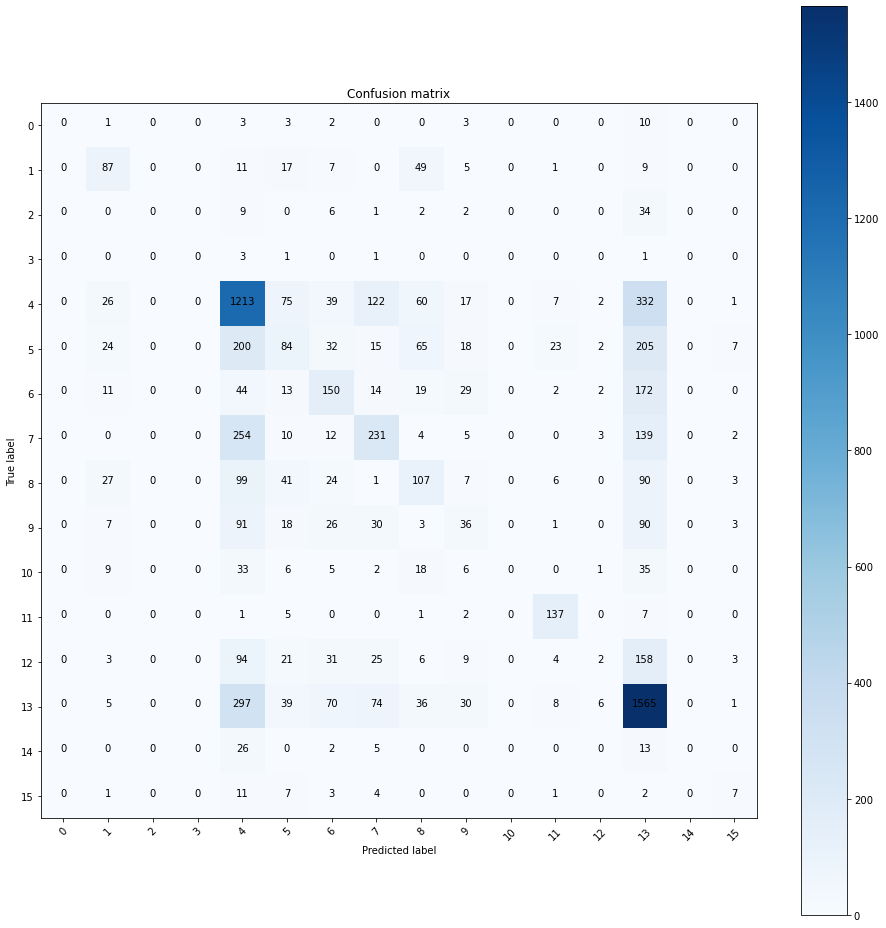

In [38]:
plt.rcParams['figure.figsize'] = (13, 13)

cm1=confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm1, classes=clf1.classes_,
                      title='Confusion matrix')



plt.show()

## ROCK CURVE

In [39]:
# Binarize the output
y_testRoc = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15])
n_classes = y_testRoc.shape[1]

In [40]:
n_classes

16

In [41]:
y_testRoc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [42]:
y_testRoc[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [43]:
y_score= clf1.predict_proba(X_test)
y_score

array([[0.  , 0.  , 0.01, ..., 0.08, 0.  , 0.05],
       [0.  , 0.  , 0.  , ..., 0.7 , 0.02, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.11, 0.  , 0.02],
       ...,
       [0.  , 0.  , 0.  , ..., 0.25, 0.  , 0.  ],
       [0.03, 0.  , 0.  , ..., 0.27, 0.  , 0.  ],
       [0.  , 0.  , 0.04, ..., 0.38, 0.03, 0.  ]])

In [44]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_testRoc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_testRoc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

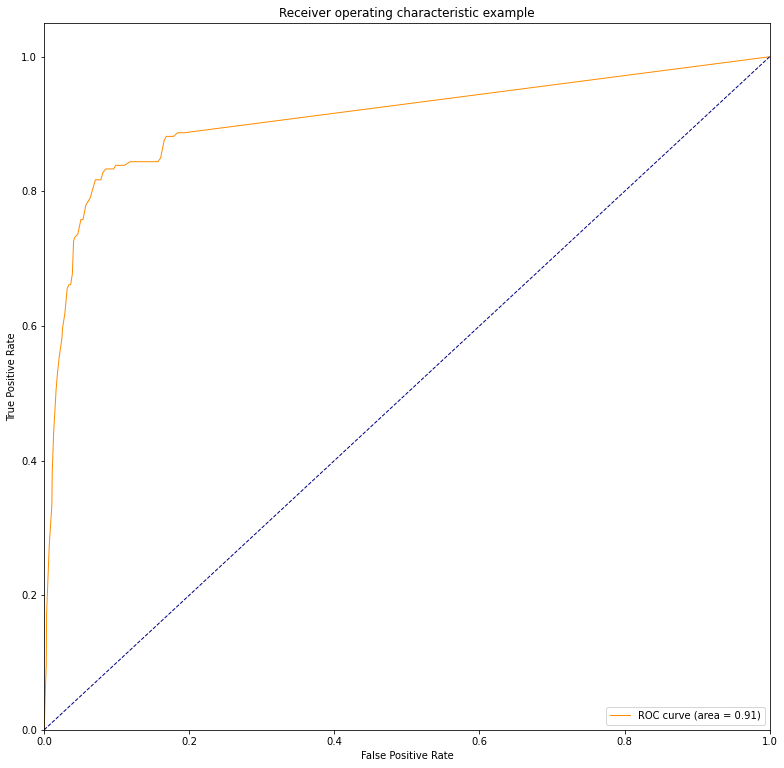

In [45]:
plt.figure()
lw = 1
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

<ipython-input-46-0f9c807e191d>:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


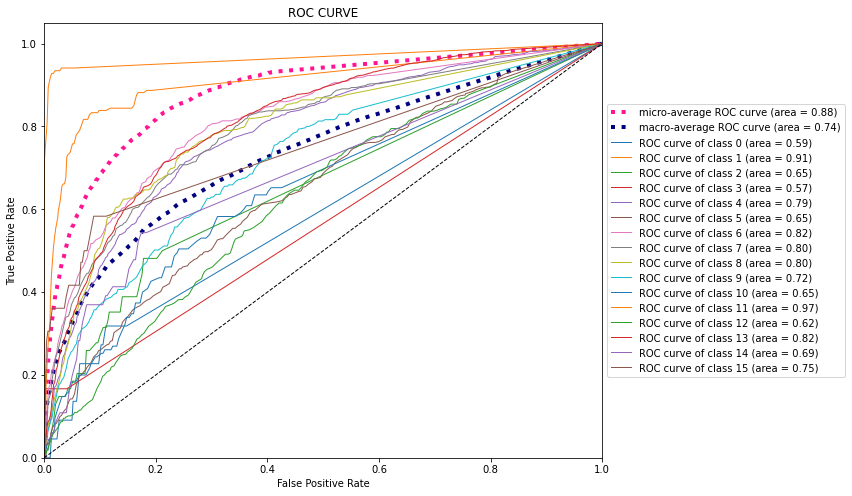

In [46]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')

# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## PRECISION - RECALL

In [61]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_testRoc[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_testRoc[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_testRoc.ravel(),
    y_score.ravel())
average_precision["macro"] = average_precision_score(y_testRoc, y_score,
                                                     average="macro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["macro"]))

Average precision score, micro-averaged over all classes: 0.24


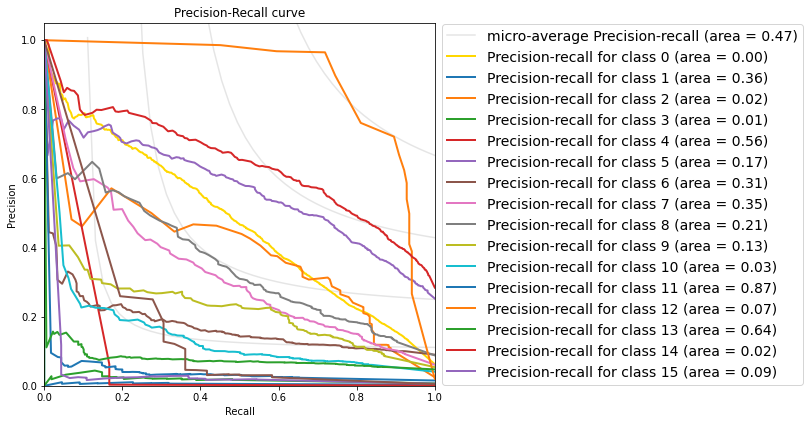

In [48]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])





plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)



lines.append(l)
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')

plt.legend(lines, labels, loc='center left', prop=dict(size=14),bbox_to_anchor=(1, 0.5))


plt.show()

In [49]:
labels

['micro-average Precision-recall (area = 0.47)',
 'Precision-recall for class 0 (area = 0.00)',
 'Precision-recall for class 1 (area = 0.36)',
 'Precision-recall for class 2 (area = 0.02)',
 'Precision-recall for class 3 (area = 0.01)',
 'Precision-recall for class 4 (area = 0.56)',
 'Precision-recall for class 5 (area = 0.17)',
 'Precision-recall for class 6 (area = 0.31)',
 'Precision-recall for class 7 (area = 0.35)',
 'Precision-recall for class 8 (area = 0.21)',
 'Precision-recall for class 9 (area = 0.13)',
 'Precision-recall for class 10 (area = 0.03)',
 'Precision-recall for class 11 (area = 0.87)',
 'Precision-recall for class 12 (area = 0.07)',
 'Precision-recall for class 13 (area = 0.64)',
 'Precision-recall for class 14 (area = 0.02)',
 'Precision-recall for class 15 (area = 0.09)']

In [65]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_testRoc[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_testRoc[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_testRoc.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_testRoc, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.47


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.47')

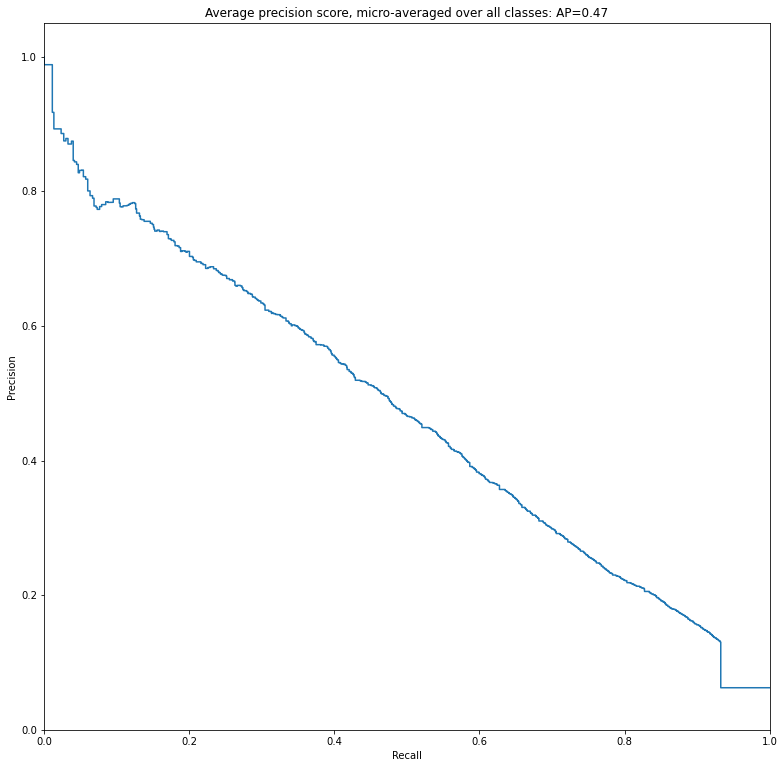

In [66]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

NameError: name 'Y_test' is not defined